pca

In [1]:
OHCO = ['genre','author','book_id','chap_num','para_num','sent_num','token_num']

SENTS = OHCO[:6]
PARAS = OHCO[:5]
CHAPS = OHCO[:4]
BOOKS = OHCO[:3]
AUTHOR = OHCO[:2]
GENRE = OHCO[:1]

In [2]:
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'YlGnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import norm

import seaborn as sns

sns.set(style='ticks')
%matplotlib inline

In [4]:
LIB = pd.read_csv('LIB.csv')
VOCAB = pd.read_csv('VOCAB2.csv').set_index('term_id')
TOKENS = pd.read_csv('TOKEN2.csv')

In [5]:
TOKENS = pd.merge(TOKENS,LIB, how = 'inner', on = 'book_id')

In [6]:
genre = [(141,'n'),(121,'n'), (42671,'n')]
genre_df = pd.DataFrame(genre,columns=('book_id','genre')).set_index('book_id')

In [7]:
LIB = pd.merge(LIB,genre_df, how = 'inner', on = 'book_id')

In [8]:
TOKENS = pd.merge(TOKENS,genre_df, how = 'inner', on = 'book_id')

In [9]:
TOKENS.set_index(OHCO)

pos_tuple  \
genre author book_id chap_num para_num sent_num token_num                            
n     austen 141     49       1        0        0                  ('About', 'IN')   
                                                1                 ('thirty', 'CD')   
                                                2                 ('years', 'NNS')   
                                                3                    ('ago', 'RB')   
                                                4                  ('Miss', 'NNP')   
...                                                                            ...   
             42671   61       19       0        4             ('GUTENBERG', 'NNP')   
                                                5                 ('EBOOK', 'NNP')   
                                                6                 ('PRIDE', 'NNP')   
                                                7                   ('AND', 'NNP')   
                                                8          ('PREJUDICE***', 'NNP')   

                                                           pos     token_str  \
genre author book_id chap_num para_num sent_num token_num                      
n     austen 141     49       1        0        0           IN         About   
                                                1           CD        thirty   
                                                2          NNS         years   
                                                3           RB           ago   
                                                4          NNP          Miss   
...                                                        ...           ...   
             42671   61       19       0        4          NNP     GUTENBERG   
                                                5          NNP         EBOOK   
                                                6          NNP         PRIDE   
                                                7          NNP           AND   
                                                8          NNP  PREJUDICE***   

                                                            term_str  term_id  \
genre author book_id chap_num para_num sent_num token_num                       
n     austen 141     49       1        0        0              about       44   
                                                1             thirty    10554   
                                                2              years    11832   
                                                3                ago      312   
                                                4               miss     6704   
...                                                              ...      ...   
             42671   61       19       0        4          gutenberg     4775   
                                                5              ebook     3362   
                                                6              pride     8018   
                                                7                and      467   
                                                8          prejudice     7939   

                                                                                            book_title  \
genre author book_id chap_num para_num sent_num token_num                                                
n     austen 141     49       1        0        0                       Mansfield Park, by Jane Austen   
                                                1                       Mansfield Park, by Jane Austen   
                                                2                       Mansfield Park, by Jane Austen   
                                                3                       Mansfield Park, by Jane Austen   
                                                4                       Mansfield Park, by Jane Austen   
...                                                                                                ...   
           

In [10]:
TOKENS = TOKENS[~TOKENS.term_str.isna()]

In [11]:
VOCAB['pos_max'] = TOKENS.groupby(['term_id', 'pos']).pos.count().unstack().idxmax(1)

if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank2', 'index':'n', 'n':'nn'})\
    .set_index('n')

VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1

VOCAB['p'] = VOCAB.n / VOCAB.shape[0]

VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2
VOCAB['zipf_k3'] = VOCAB.p * VOCAB.term_rank2

In [12]:
def TFIDF_Matrix(df,bag,count_type,tf_type,idf_type):

    BOW = TOKENS.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})

    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    
    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T

    DF = DTCM[DTCM > 0].count()

    N = DTCM.shape[0]

    if idf_method == 'standard':
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1

    TFIDF = TF * IDF

    VOCAB['df'] = DF
    VOCAB['idf'] = IDF

    BOW['tf'] = TF.stack()
    BOW['tfidf'] = TFIDF.stack()

    VOCAB['tfidf_sum'] = TFIDF.sum()

    VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient\
        (cmap=gradient_cmap, high=1)

    VOCAB[['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False).head(50)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    VOCAB.loc[VOCAB.pos_max != 'NNP', ['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False)\
        .head(50).style.background_gradient(cmap=gradient_cmap, high=1)
    
    BOW = BOW.join(VOCAB[['term_str','pos_max']], on='term_id')

    BOW.sort_values('tfidf', ascending=False).head(20)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    return TFIDF

In [13]:
def BOW_Matrix(df,bag,count_type,tf_type,idf_type):

    BOW = TOKENS.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})

    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    
    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T

    DF = DTCM[DTCM > 0].count()

    N = DTCM.shape[0]

    if idf_method == 'standard':
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1

    TFIDF = TF * IDF

    VOCAB['df'] = DF
    VOCAB['idf'] = IDF

    BOW['tf'] = TF.stack()
    BOW['tfidf'] = TFIDF.stack()

    VOCAB['tfidf_sum'] = TFIDF.sum()

    VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient\
        (cmap=gradient_cmap, high=1)

    VOCAB[['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False).head(50)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    VOCAB.loc[VOCAB.pos_max != 'NNP', ['term_rank','term_str','pos_max','tfidf_sum']]\
        .sort_values('tfidf_sum', ascending=False)\
        .head(50).style.background_gradient(cmap=gradient_cmap, high=1)
    
    BOW = BOW.join(VOCAB[['term_str','pos_max']], on='term_id')

    BOW.sort_values('tfidf', ascending=False).head(20)\
        .style.background_gradient(cmap=gradient_cmap, high=1)

    return BOW
    

In [14]:
TFIDF = TFIDF_Matrix(TOKENS,BOOKS,count_method,tf_method,idf_method)

In [15]:
BOW = BOW_Matrix(TOKENS,BOOKS,count_method,tf_method,idf_method)

In [16]:
TFIDF

term_id                  1         2         3         4         5      \
genre author book_id                                                     
n     austen 121      0.000006  0.000000  0.000000  0.000000  0.000006   
             141      0.000000  0.000009  0.000006  0.000000  0.000000   
             42671    0.000000  0.000000  0.000000  0.000004  0.000000   

term_id                  6         7         8         9         10     ...  \
genre author book_id                                                    ...   
n     austen 121      0.000012  0.000000  0.000006  0.000006  0.000000  ...   
             141      0.000000  0.000000  0.000000  0.000000  0.000000  ...   
             42671    0.000000  0.000008  0.000000  0.000000  0.000004  ...   

term_id               11873     11874  11875  11876     11877     11878  \
genre author book_id                                                      
n     austen 121        0.0  0.000000    0.0    0.0  0.000012  0.000000   
             141        0.0  0.000000    0.0    0.0  0.000000  0.000000   
             42671      0.0  0.000004    0.0    0.0  0.000000  0.000004   

term_id                  11879     11880     11881     11882  
genre author book_id                                          
n     austen 121      0.000000  0.000000  0.000000  0.000000  
             141      0.000000  0.000015  0.000003  0.000003  
             42671    0.000004  0.000000  0.000000  0.000000  

[3 rows x 11882 columns]

In [17]:
BOW

n  c        tf     tfidf     term_str pos_max
genre author book_id term_id                                               
n     austen 121     1        1  1  0.000013  0.000006            1      JJ
                     5        1  1  0.000013  0.000006       179798      JJ
                     6        2  1  0.000026  0.000012         1803      CD
                     8        1  1  0.000013  0.000006         1816      CD
                     9        1  1  0.000013  0.000006         1818      CD
...                          .. ..       ...       ...          ...     ...
             42671   11874    1  1  0.000008  0.000004  yourselfand      NN
                     11875    2  1  0.000016  0.000000   yourselves      NN
                     11876    9  1  0.000074  0.000000        youth      NN
                     11878    1  1  0.000008  0.000004       youths     NNS
                     11879    1  1  0.000008  0.000004      youwill      VB

[21107 rows x 6 columns]

In [18]:
DTCM = BOW[count_method].unstack().fillna(0).astype('int')

In [19]:
DTCM.head(10)

term_id               1      2      3      4      5      6      7      8      \
genre author book_id                                                           
n     austen 121          1      0      0      0      1      2      0      1   
             141          0      3      2      0      0      0      0      0   
             42671        0      0      0      1      0      0      2      0   

term_id               9      10     ...  11873  11874  11875  11876  11877  \
genre author book_id                ...                                      
n     austen 121          1      0  ...     22      0      1      4      2   
             141          0      0  ...     58      0      3      6      0   
             42671        0      1  ...     49      1      2      9      0   

term_id               11878  11879  11880  11881  11882  
genre author book_id                                     
n     austen 121          0      0      0      0      0  
             141          0      0      5      1      1  
             42671        1      1      0      0      0  

[3 rows x 11882 columns]

In [20]:
reduced_vocab = VOCAB[VOCAB['tfidf_sum']>0]

In [21]:
reduced_vocab

,term_rank,term_str,n,num,stop,p_stem,pos_max,term_rank2,p,zipf_k,zipf_k2,zipf_k3,df,idf,tfidf_sum
term_id,,,,,,,,,,,,,,,
3976,67,fanny,816,0,0,fanni,NNP,67,0.068675,54672,54672,4.601246,1,0.477121,0.002436
3440,90,elizabeth,585,0,0,elizabeth,NNP,89,0.049234,52650,52065,4.381838,1,0.477121,0.002294
1524,95,catherine,538,0,0,catherin,NNP,94,0.045279,51110,50572,4.256186,2,0.176091,0.001132
2402,102,crawford,493,0,0,crawford,NNP,101,0.041491,50286,49793,4.190624,1,0.477121,0.001472
2521,126,darcy,365,0,0,darci,NNP,123,0.030719,45990,44895,3.778404,1,0.477121,0.001431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723,11878,interfered,1,0,0,interf,VBD,374,0.000084,11878,374,0.031476,1,0.477121,0.000003
5716,11879,intercepting,1,0,0,intercept,VBG,374,0.000084,11879,374,0.031476,1,0.477121,0.000006
5715,11880,intercept,1,0,0,intercept,VB,374,0.000084,11880,374,0.031476,1,0.477121,0.000003


In [22]:
reduced_vocab = reduced_vocab.sort_values('tfidf_sum',ascending=False).head(4000)

In [23]:
reduced_vocab

,term_rank,term_str,n,num,stop,p_stem,pos_max,term_rank2,p,zipf_k,zipf_k2,zipf_k3,df,idf,tfidf_sum
term_id,,,,,,,,,,,,,,,
3976,67,fanny,816,0,0,fanni,NNP,67,0.068675,54672,54672,4.601246,1,0.477121,0.002436
3440,90,elizabeth,585,0,0,elizabeth,NNP,89,0.049234,52650,52065,4.381838,1,0.477121,0.002294
2402,102,crawford,493,0,0,crawford,NNP,101,0.041491,50286,49793,4.190624,1,0.477121,0.001472
2521,126,darcy,365,0,0,darci,NNP,123,0.030719,45990,44895,3.778404,1,0.477121,0.001431
10621,228,tilney,196,0,0,tilney,NNP,195,0.016496,44688,38220,3.216630,1,0.477121,0.001207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9075,4871,sakes,3,0,0,sake,NN,372,0.000252,14613,1116,0.093924,2,0.176091,0.000004
479,5517,anguish,3,0,0,anguish,JJ,372,0.000252,16551,1116,0.093924,2,0.176091,0.000004
6941,4772,neglecting,3,0,0,neglect,VBG,372,0.000252,14316,1116,0.093924,2,0.176091,0.000004


In [24]:
terms = list(reduced_vocab.index)

In [25]:
TFIDF = TFIDF.filter(terms)

In [26]:
TFIDF

term_id                  3976      3440      2402      2521      10621  \
genre author book_id                                                     
n     austen 121      0.000000  0.000000  0.000000  0.000000  0.001207   
             141      0.002436  0.000000  0.001472  0.000000  0.000000   
             42671    0.000000  0.002294  0.000000  0.001431  0.000000   

term_id                  1043      1524     3385      5865      1104   ...  \
genre author book_id                                                   ...   
n     austen 121      0.000000  0.000973  0.00000  0.000000  0.000000  ...   
             141      0.000000  0.000000  0.00109  0.000000  0.000000  ...   
             42671    0.001149  0.000159  0.00000  0.001012  0.000992  ...   

term_id                  9195      7885      8350      8648      9632   \
genre author book_id                                                     
n     austen 121      0.000000  0.000000  0.000000  0.000000  0.000000   
             141      0.000001  0.000001  0.000001  0.000001  0.000001   
             42671    0.000003  0.000003  0.000003  0.000003  0.000003   

term_id                  9075      479       6941      6567      2126   
genre author book_id                                                    
n     austen 121      0.000000  0.000000  0.000000  0.000000  0.000000  
             141      0.000001  0.000001  0.000001  0.000001  0.000001  
             42671    0.000003  0.000003  0.000003  0.000003  0.000003  

[3 rows x 4000 columns]

In [27]:
%time COV = TFIDF.T.dot(TFIDF) / (TFIDF.shape[0] - 1)

CPU times: user 240 ms, sys: 168 ms, total: 408 ms
Wall time: 294 ms


In [28]:
from scipy.linalg import eigh

In [29]:
%time eig_vals, eig_vecs = eigh(COV)

CPU times: user 22.5 s, sys: 649 ms, total: 23.2 s
Wall time: 14.8 s


In [30]:
TERM_IDX = COV.index

In [31]:
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)

In [32]:
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'

In [33]:
EIG_VEC.iloc[:5, :10].style.background_gradient()

term_id,3976,3440,2402,2521,10621,1043,1524,3385,5865,1104
term_id,,,,,,,,,,
3976,0.013003,0.032455,0.028792,-0.047894,-0.288878,-0.330640,0.236469,-0.145642,0.000000,0.000000
3440,0.396249,-0.206027,-0.069637,-0.174639,0.091987,0.150081,-0.022348,0.039841,-0.137459,0.058458
2402,-0.495777,-0.467518,-0.094253,0.011898,0.175959,0.219861,-0.071311,0.058380,0.017142,0.000158
2521,-0.119229,-0.339474,0.047046,-0.371267,-0.059728,-0.149263,-0.098040,0.091723,0.012645,0.014923
10621,0.318034,0.042799,0.018153,-0.142963,0.121737,-0.061306,-0.108336,0.069294,0.196996,-0.121014


In [34]:
EIG_VAL.iloc[:10]

,eig_val
term_id,
3976,-2.164838e-20
3440,-1.230880e-20
2402,-5.779346e-21
2521,-5.599413e-21
10621,-4.270649e-21
1043,-3.574883e-21
1524,-2.170026e-21
3385,-8.028330e-22
5865,-1.097244e-22


In [35]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_id'>

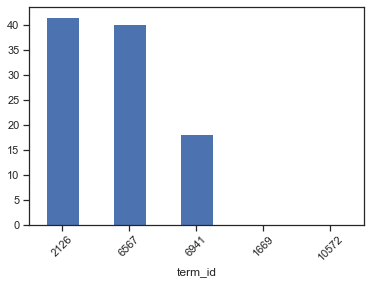

In [36]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [37]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

In [38]:
COMPS

,eig_val,3976,3440,2402,2521,10621,1043,1524,3385,5865,...,7885,8350,8648,9632,9075,479,6941,6567,2126,exp_var
PC0,6.415178e-06,0.047617,6.385737e-01,2.876854e-02,3.984263e-01,7.720324e-03,3.198326e-01,5.053765e-02,2.129923e-02,2.816274e-01,...,0.000827,0.000827,0.000827,0.000827,0.000827,0.000827,0.000827,0.000827,0.000827,41.58
PC1,6.207775e-06,-0.689692,4.564380e-02,-4.166890e-01,2.847861e-02,-1.388337e-03,2.286091e-02,2.048679e-03,-3.085020e-01,2.013008e-02,...,-0.000254,-0.000254,-0.000254,-0.000254,-0.000254,-0.000254,-0.000254,-0.000254,-0.000254,40.23
PC2,2.806171e-06,-0.005808,-2.185102e-02,-3.509252e-03,-1.363354e-02,5.093703e-01,-1.094419e-02,4.089998e-01,-2.598128e-03,-9.636861e-03,...,-0.000030,-0.000030,-0.000030,-0.000030,-0.000030,-0.000030,-0.000030,-0.000030,-0.000030,18.19
PC3,1.986745e-42,0.000000,4.443814e-18,3.582418e-18,2.381318e-18,3.361072e-18,3.202624e-18,-5.272364e-18,1.012136e-18,-7.773440e-19,...,0.001786,0.016868,0.012910,0.022334,0.027817,-0.014584,0.014584,-0.009799,0.009799,0.00
PC4,2.011419e-42,0.000000,-1.665716e-18,-6.927129e-19,-1.613009e-18,-4.647200e-18,-1.615077e-20,-5.554786e-19,-3.634683e-18,3.432589e-18,...,-0.020772,0.010965,-0.019025,0.005550,0.032350,0.007271,-0.007271,-0.010076,0.010076,0.00
PC5,2.007060e-42,0.000000,-1.560038e-18,-1.057765e-18,-1.815323e-18,-4.038426e-18,-2.894384e-18,2.077505e-19,-2.602598e-18,9.253724e-19,...,-0.014836,0.002695,-0.016860,0.057394,0.018877,0.016501,-0.016501,0.009668,-0.009668,0.00
PC6,1.990927e-42,0.000000,-2.703045e-18,-3.643427e-18,2.550855e-19,4.003600e-18,6.692077e-19,-9.034582e-18,5.012517e-18,3.154344e-18,...,-0.016984,0.002863,0.007482,0.007657,-0.002763,0.004951,-0.004951,0.027944,-0.027944,0.00
PC7,1.990694e-42,0.000000,-4.052077e-18,-2.673159e-18,-1.774230e-18,-1.979407e-18,-2.945788e-18,1.818753e-18,-1.572715e-18,6.022296e-18,...,-0.004479,-0.015921,-0.011388,0.007270,0.013280,0.014414,-0.014414,-0.004332,0.004332,0.00
PC8,1.989026e-42,0.000000,-2.346312e-18,-2.256051e-18,-2.322379e-18,4.026998e-18,-3.544801e-18,2.203984e-18,1.396294e-18,3.051811e-19,...,-0.019084,0.024401,0.000638,0.022851,0.017484,-0.038223,0.038223,-0.005183,0.005183,0.00
PC9,1.973648e-42,0.000000,7.977948e-18,7.144988e-18,4.125818e-18,-1.117072e-17,3.682201e-18,1.381512e-19,-3.341353e-18,-6.394394e-18,...,0.005512,0.019865,0.017263,0.000936,0.010017,-0.022754,0.022754,0.006553,-0.006553,0.00


In [39]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'

LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [40]:
l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [41]:
print('Books PC0+', l0_pos)
print('Books PC0-', l0_neg)
print('Books PC1+', l1_pos)
print('Books PC1-', l1_neg)

Books PC0+ string swearing slighting uncensured sleeve sweat sweepgate sliding roared venerating
Books PC0- elizabeth darcy bennet jane bingley collins wickham lydia lizzy longbourn
Books PC1+ fanny crawford edmund thomas bertram rushworth norris mansfield grant crawfords
Books PC1- elizabeth darcy bennet jane bingley collins wickham lydia lizzy longbourn


In [42]:
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']

term_id
2126        conquer
6567          meets
6941     neglecting
4143           firs
4155      fittingup
4168       flatness
4174      flavoured
4181    flirtations
4191         florid
4095          fiend
Name: term_str, dtype: object

In [43]:
DCM = TFIDF.dot(COMPS[TERM_IDX].T)

In [44]:
DCM

PC0       PC1       PC2           PC3  \
genre author book_id                                               
n     austen 121      0.000082 -0.000014  0.002368 -6.559575e-22   
             141      0.000251 -0.003515 -0.000013 -9.793818e-22   
             42671    0.003572  0.000247 -0.000053  2.249931e-22   

                               PC4           PC5           PC6           PC7  \
genre author book_id                                                           
n     austen 121      2.547716e-21 -4.939712e-22 -8.910846e-22 -7.421869e-23   
             141      1.747005e-21 -1.045556e-21 -1.637818e-22  5.955700e-22   
             42671    7.610062e-22 -6.749794e-22  3.044025e-21  5.823352e-22   

                               PC8           PC9  
genre author book_id                              
n     austen 121     -5.942309e-22 -1.490683e-21  
             141     -6.305184e-22 -3.573420e-22  
             42671   -8.999725e-22  2.845501e-22

In [45]:
LIB

,book_id,book_title,book_file,author,title,year,genre
0,141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814,n
1,121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803,n
2,42671,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813,n


In [46]:
DCM = LIB.merge(DCM, on='book_id')

In [47]:
DCM

,book_id,book_title,book_file,author,title,year,genre,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814,n,0.000251,-0.003515,-0.000013,-9.793818e-22,1.747005e-21,-1.045556e-21,-1.637818e-22,5.955700e-22,-6.305184e-22,-3.573420e-22
1,121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803,n,0.000082,-0.000014,0.002368,-6.559575e-22,2.547716e-21,-4.939712e-22,-8.910846e-22,-7.421869e-23,-5.942309e-22,-1.490683e-21
2,42671,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813,n,0.003572,0.000247,-0.000053,2.249931e-22,7.610062e-22,-6.749794e-22,3.044025e-21,5.823352e-22,-8.999725e-22,2.845501e-22


In [50]:
DCM['doc'] = DCM.apply(lambda x: "{}-{}-{}".format(x.genre, x.author, x.title[1]), 1)

In [51]:
DCM

,book_id,book_title,book_file,author,title,year,genre,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,doc
0,141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814,n,0.000251,-0.003515,-0.000013,-9.793818e-22,1.747005e-21,-1.045556e-21,-1.637818e-22,5.955700e-22,-6.305184e-22,-3.573420e-22,n-austen-a
1,121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803,n,0.000082,-0.000014,0.002368,-6.559575e-22,2.547716e-21,-4.939712e-22,-8.910846e-22,-7.421869e-23,-5.942309e-22,-1.490683e-21,n-austen-o
2,42671,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813,n,0.003572,0.000247,-0.000053,2.249931e-22,7.610062e-22,-6.749794e-22,3.044025e-21,5.823352e-22,-8.999725e-22,2.845501e-22,n-austen-r


In [52]:
import plotly.express as px

In [53]:
def vis_pcs(M, a, b, label='book', prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label, 
                        hover_name='book_id', marginal_x='box')
    fig.show()

In [54]:
vis_pcs(DCM, 0, 1, label = 'title')

In [56]:
vis_pcs(DCM, 1, 2, label = 'title')